In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-aug-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-aug-2022/train.csv
/kaggle/input/tabular-playground-series-aug-2022/test.csv


## Using skops to host your models on Hugging Face Hub
This notebook shows you how you can use [skops](https://skops.readthedocs.io/) to improve your data science workflows with scikit-learn. We will have end-to-end example for Kaggle Tabular Playground Series of August 2022.

## Install skops

In [58]:
#!pip install skops

## Import libraries

In [36]:
import skops
import sklearn
import matplotlib.pyplot as plt

## Let's take a look at the dataset
Target variable is a binary category. We have couple of numerical and categorical variables.

In [37]:
df = pd.read_csv("../input/tabular-playground-series-aug-2022/train.csv")
df.head()

id product_code  loading attribute_0 attribute_1  attribute_2  attribute_3  \
0   0            A    80.10  material_7  material_8            9            5   
1   1            A    84.89  material_7  material_8            9            5   
2   2            A    82.43  material_7  material_8            9            5   
3   3            A   101.07  material_7  material_8            9            5   
4   4            A   188.06  material_7  material_8            9            5   

   measurement_0  measurement_1  measurement_2  ...  measurement_9  \
0              7              8              4  ...         10.672   
1             14              3              3  ...         12.448   
2             12              1              5  ...         12.715   
3             13              2              6  ...         12.471   
4              9              2              8  ...         10.337   

   measurement_10  measurement_11  measurement_12  measurement_13  \
0          15.859          17.594          15.193          15.029   
1          17.947          17.915          11.755          14.732   
2          15.607             NaN          13.798          16.711   
3          16.346          18.377          10.020          15.250   
4          17.082          19.932          12.428          16.182   

   measurement_14  measurement_15  measurement_16  measurement_17  failure  
0             NaN          13.034          14.684         764.100        0  
1          15.425          14.395          15.631         682.057        0  
2          18.631          14.094          17.946         663.376        0  
3          15.562          16.154          17.172         826.282        0  
4          12.760          13.153          16.412         579.885        0  

[5 rows x 26 columns]

In [38]:
df["failure"].unique()

array([0, 1])

# Encode categorical variables, impute missing values
We will impute mean for the numerical attribues and measurements. 

In [39]:
df.describe()

id       loading   attribute_2   attribute_3  measurement_0  \
count  26570.000000  26320.000000  26570.000000  26570.000000   26570.000000   
mean   13284.500000    127.826233      6.754046      7.240459       7.415883   
std     7670.242662     39.030020      1.471852      1.456493       4.116690   
min        0.000000     33.160000      5.000000      5.000000       0.000000   
25%     6642.250000     99.987500      6.000000      6.000000       4.000000   
50%    13284.500000    122.390000      6.000000      8.000000       7.000000   
75%    19926.750000    149.152500      8.000000      8.000000      10.000000   
max    26569.000000    385.860000      9.000000      9.000000      29.000000   

       measurement_1  measurement_2  measurement_3  measurement_4  \
count   26570.000000   26570.000000   26189.000000   26032.000000   
mean        8.232518       6.256568      17.791528      11.731988   
std         4.199401       3.309109       1.001200       0.996085   
min         0.000000       0.000000      13.968000       8.008000   
25%         5.000000       4.000000      17.117000      11.051000   
50%         8.000000       6.000000      17.787000      11.733000   
75%        11.000000       8.000000      18.469000      12.410000   
max        29.000000      24.000000      21.499000      16.484000   

       measurement_5  ...  measurement_9  measurement_10  measurement_11  \
count   25894.000000  ...   25343.000000    25270.000000    25102.000000   
mean       17.127804  ...      11.430725       16.117711       19.172085   
std         0.996414  ...       0.999137        1.405978        1.520785   
min        12.073000  ...       7.537000        9.323000       12.461000   
25%        16.443000  ...      10.757000       15.209000       18.170000   
50%        17.132000  ...      11.430000       16.127000       19.211500   
75%        17.805000  ...      12.102000       17.025000       20.207000   
max        21.425000  ...      15.412000       22.479000       25.640000   

       measurement_12  measurement_13  measurement_14  measurement_15  \
count    24969.000000    24796.000000    24696.000000    24561.000000   
mean        11.702464       15.652904       16.048444       14.995554   
std          1.488838        1.155247        1.491923        1.549226   
min          5.167000       10.890000        9.140000        9.104000   
25%         10.703000       14.890000       15.057000       13.957000   
50%         11.717000       15.628500       16.040000       14.969000   
75%         12.709000       16.374000       17.082000       16.018000   
max         17.663000       22.713000       22.303000       21.626000   

       measurement_16  measurement_17       failure  
count    24460.000000    24286.000000  26570.000000  
mean        16.460727      701.269059      0.212608  
std          1.708935      123.304161      0.409160  
min          9.701000      196.787000      0.000000  
25%         15.268000      618.961500      0.000000  
50%         16.436000      701.024500      0.000000  
75%         17.628000      784.090250      0.000000  
max         24.094000     1312.794000      1.000000  

[8 rows x 23 columns]

Take a look at the missing values and data types.

In [40]:
df.isna().any()

id                False
product_code      False
loading            True
attribute_0       False
attribute_1       False
attribute_2       False
attribute_3       False
measurement_0     False
measurement_1     False
measurement_2     False
measurement_3      True
measurement_4      True
measurement_5      True
measurement_6      True
measurement_7      True
measurement_8      True
measurement_9      True
measurement_10     True
measurement_11     True
measurement_12     True
measurement_13     True
measurement_14     True
measurement_15     True
measurement_16     True
measurement_17     True
failure           False
dtype: bool

In [41]:
df.dtypes

id                  int64
product_code       object
loading           float64
attribute_0        object
attribute_1        object
attribute_2         int64
attribute_3         int64
measurement_0       int64
measurement_1       int64
measurement_2       int64
measurement_3     float64
measurement_4     float64
measurement_5     float64
measurement_6     float64
measurement_7     float64
measurement_8     float64
measurement_9     float64
measurement_10    float64
measurement_11    float64
measurement_12    float64
measurement_13    float64
measurement_14    float64
measurement_15    float64
measurement_16    float64
measurement_17    float64
failure             int64
dtype: object

Let's see the cardinality of categorical variables.

In [42]:
print(df.product_code.nunique())
print(df.attribute_0.nunique())
print(df.attribute_0.nunique())


5
2
2


# Preprocessing 
We will use OneHotEncoder to encode our categorical variables, SimpleImputer to impute missing values and put them all in a ColumnTransformer. We will then use the transformer in our machine learning pipeline to have an end-to-end object for better reproducibility.

In [43]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

column_transformer_pipeline = ColumnTransformer([
                ("loading_missing_value_imputer", SimpleImputer(strategy="mean"), ["loading"]),
                ("numerical_missing_value_imputer", SimpleImputer(strategy="mean"), list(df.columns[df.dtypes == 'float64'])),
                ("attribute_0_encoder", OneHotEncoder(categories = "auto"), ["attribute_0"]),
                ("attribute_1_encoder", OneHotEncoder(categories = "auto"), ["attribute_1"]),
                ("product_code_encoder", OneHotEncoder(categories = "auto"), ["product_code"])])

In [44]:
df = df.drop(["id"], axis=1)

In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('transformation', column_transformer_pipeline),
    ('model', DecisionTreeClassifier(max_depth=4))
])

In [46]:
X = df.drop(["failure"], axis = 1)
y = df.failure

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [48]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformation',
                 ColumnTransformer(transformers=[('loading_missing_value_imputer',
                                                  SimpleImputer(),
                                                  ['loading']),
                                                 ('numerical_missing_value_imputer',
                                                  SimpleImputer(),
                                                  ['loading', 'measurement_3',
                                                   'measurement_4',
                                                   'measurement_5',
                                                   'measurement_6',
                                                   'measurement_7',
                                                   'measurement_8',
                                                   'measurement_9',
                                                   'measurement_10',
                                           

In [49]:
y_pred = pipeline.predict(X_test)

# We will now save the model and create a model card with metrics about our model!

We will use `hub_utils` for model hosting and `card` to create a model card. First, we will initialize a local repository to contain our model, model configuration, model card and anything else that we want. (e.g. plots)

In [50]:
from skops import card, hub_utils
import pickle

model_path = "model.pkl"
local_repo = "decision-tree-playground-kaggle"

with open(model_path, mode="bw") as f:
    pickle.dump(pipeline, file=f)

hub_utils.init(
model=model_path, 
requirements=[f"scikit-learn={sklearn.__version__}"], 
dst=local_repo,
task="tabular-classification",
data=X_test,
)

## We will now create our card 🃏 

Creating the model card is as simple as instantiating `Card` class of `skops`. Calling `metadata_from_config` method will create metadata section of the model card from configuration file. We will use `add` method to pass information to our model card.

In [51]:
from pathlib import Path
model_card = card.Card(pipeline, metadata=card.metadata_from_config(Path(local_repo)))

## let's fill some information about the model
limitations = "This model is not ready to be used in production."
model_description = "This is a DecisionTreeClassifier model built for Kaggle Tabular Playground Series August 2022, trained on supersoaker production failures dataset."
model_card_authors = "huggingface"
get_started_code = f"import pickle \nwith open({local_repo}/{model_path}, 'rb') as file: \n    clf = pickle.load(file)"

# pass this information to the card
model_card.add(
    get_started_code=get_started_code,
    model_card_authors=model_card_authors,
    limitations=limitations,
    model_description=model_description,
)
# adding methods return the model card itself for easy method chaining

Card(
  model=Pipeline(steps=[('transformat...cisionTreeClassifier(max_depth=4))]),
  metadata.library_name=sklearn,
  metadata.tags=['sklearn', 'skops', 'tabular-classification'],
  metadata.widget={...},
  get_started_code="import pickle \\n...s file: \\n clf = pickle.load(file)",
  model_card_authors='huggingface',
  limitations='This model is not ready to be used in production.',
  model_description='This is a Decisi...soaker production failures dataset.',
)

We will now plot and create insights about our model and write them to the model card. 
Pipeline includes the decision tree in the last step of it, you can see the content of pipeline as a tuple. The second element of the tuple includes the object -the tree model- itself so if we want to plot the tree we have to first get it from the pipeline. (see below)

In [52]:
pipeline.steps[-1][1]

DecisionTreeClassifier(max_depth=4)

We can use `add_metrics` to pass metrics to our model card, which skops will parse into a table for us. We will use `add_plots` to add our plots. 

Card(
  model=Pipeline(steps=[('transformat...cisionTreeClassifier(max_depth=4))]),
  metadata.library_name=sklearn,
  metadata.tags=['sklearn', 'skops', 'tabular-classification'],
  metadata.widget={...},
  get_started_code="import pickle \\n...s file: \\n clf = pickle.load(file)",
  model_card_authors='huggingface',
  limitations='This model is not ready to be used in production.',
  model_description='This is a Decisi...soaker production failures dataset.',
  eval_method='The model is evaluated...cy and F1 score with micro average.',
  Tree Plot='decision-tree-playground-kaggle/tree.png',
  Confusion Matrix='decision-tree-playground-kaggle/confusion_matrix.png',
)

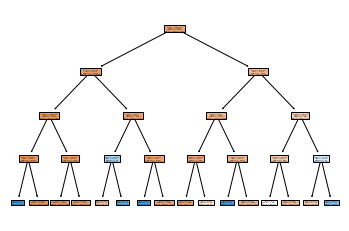

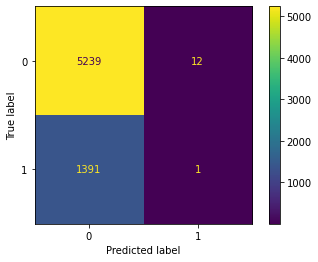

In [53]:
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
model_card.add(eval_method="The model is evaluated using test split, on accuracy and F1 score with micro average.")
model_card.add_metrics(accuracy=accuracy_score(y_test, y_pred))
model_card.add_metrics(**{"f1 score": f1_score(y_test, y_pred, average="micro")})

model = pipeline.steps[-1][1]
# we will plot the tree and add the plot to our card
from sklearn.tree import plot_tree
plt.figure()
plot_tree(model,filled=True)  
plt.savefig(f'{local_repo}/tree.png',format='png',bbox_inches = "tight")

# let's make a prediction and evaluate the model

y_pred = pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
# save the plot
plt.savefig(Path(local_repo) / "confusion_matrix.png")
# add figures to model card with their new sections as keys to the dictionary
model_card.add_plot(**{"Tree Plot": f'{local_repo}/tree.png', "Confusion Matrix": f"{local_repo}/confusion_matrix.png"})

We will now save our model card.

In [54]:
model_card.save(f"{local_repo}/README.md")

Let's push our model repository to Hub! 
Hugging Face Hub requires us to authenticate ourselves, we can do that using `notebook_login`


In [27]:
from huggingface_hub import notebook_login
notebook_login()

We can push our model using `hub_utils.push`

In [55]:
# if the repository doesn't exist remotely on the Hugging Face Hub, it will be created when we set create_remote to True
repo_id = "scikit-learn/tabular-playground"
hub_utils.push(
    repo_id=repo_id,
    source=local_repo,
    token=token,
    commit_message="pushing files to the repo from the example!",
    create_remote=True,
)


## After we push it, the widget is enabled like below:

![Widget](https://huggingface.co./scikit-learn/tabular-playground/resolve/main/widget_screenshot.png)

# See how repository and our model card looks like [here](https://huggingface.co./scikit-learn/tabular-playground)  ✨